# DSL winter project: Speaker age estimation

Simone Fassio
s342462

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from sklearn.ensemble import StackingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold
import librosa
import random
from joblib import Parallel, delayed
import seaborn as sns

random.seed(42)

In [2]:
base_path = "/iti/Data Science Lab/final_project/DSL_Winter_Project_2025/"

os.chdir(base_path)

#### Useful functions

In [3]:
def trasform_data(data):
    data = data.copy()
    Ids = data['Id']

    if 'age' in data.columns:
        y = data['age']
        data.drop(columns=['age'], inplace=True)
    else:
        y = 0

    gender_map = {'male': 1, 'female': 0}
    data['gender_male'] = data['gender'].map(gender_map).fillna(0)
    data['gender_male'].fillna(0)
    data.drop(columns=['gender'], inplace=True)
    data['tempo'] = data['tempo'].apply(lambda s : float(s[1:-1]))

    ethnicity_map = {
        'igbo' : 'igbo',
        'english' : 'english',
        'arabic' : 'arabic'
    }
    data['ethnicity'] = data['ethnicity'].map(ethnicity_map).fillna('Other')
    data["ethnicity_igbo"] = data["ethnicity"].map({"igbo" : 1}).fillna(0)
    data["ethnicity_english"] = data["ethnicity"].map({"english" : 1}).fillna(0)
    data["ethnicity_arabic"] = data["ethnicity"].map({"arabic" : 1}).fillna(0)
    data.drop(columns=['ethnicity'], inplace=True)
    
    data.drop(columns=['Id', 'sampling_rate', 'path', 'num_words'], inplace=True)
    
    X = data.to_numpy()
    return X, y, Ids, data.columns

def save_result(model, X, Ids):
    y_pred = model.predict(X)
    df = pd.DataFrame({'Id': Ids, 'Predicted': y_pred})
    df.to_csv("results.csv", index=False)

In [4]:
def extract_audio_features(id, path, base_path):
    file_path = base_path + path
    y, sr = librosa.load(file_path, sr=22050)
    features = {}
    
    features["Id"] = id
    
    # --- Fundamental Frequency (F0) Extraction ---
    pitch, voiced_flag, voiced_probs = librosa.pyin(y, fmin=50, fmax=4000)  # F0 values in Hz
    valid_pitch = pitch[voiced_flag]
    
    if len(valid_pitch) > 0:
        # Basic F0 statistics
        features["_mean_pitch"] = np.mean(valid_pitch)
        features["_max_pitch"] = np.max(valid_pitch)
        features["_min_pitch"] = np.min(valid_pitch)
        features["_pitch_std"] = np.std(valid_pitch)
        
        # Jitter
        periods = 1 / valid_pitch 
        jitter_abs = np.mean(np.abs(np.diff(periods)))
        jitter_rel = jitter_abs / np.mean(periods)  # Relative jitter
        features["_jitter"] = jitter_rel * 100
        
    else:
        features.update({k: 0.0 for k in ["_mean_pitch", "_max_pitch", "_min_pitch", 
                                        "_pitch_std", "_jitter"]})
        
    # --- Energy ---
    rms = librosa.feature.rms(y=y)[0]
    rms_db = librosa.amplitude_to_db(rms, ref=np.max)
    features["_energy_db"] = np.mean(rms_db)
    features["_max_energy_db"] = np.percentile(rms_db, 99)
    features["_min_energy_db"] = np.percentile(rms_db, 1)
    features["_energy_db_std"] = np.std(rms_db)

    # --- Pause Detection ---
    energy_threshold = 0.1 * np.percentile(rms, 99)  # Adjust threshold as needed
    silence_regions = rms < energy_threshold
    silence_durations = librosa.frames_to_time(silence_regions, sr=sr)
    features["_num_pauses"] = np.sum(np.diff(silence_regions.astype(int)) == 1)
    features["_silence_duration"] = np.sum(silence_durations)
    
    # Calculate the duration of each frame
    hop_length = 256    # Default hop length used by librosa.pyin
    frame_duration = hop_length / 22050

    # Calculate the total duration of silence
    features["_silence_duration_voiced"] = np.sum(~voiced_flag) * frame_duration
    
    #calculate silence run lenght
    min_run_length = 5
    runs_len = []
    silence_flag = ~voiced_flag
    diff = np.diff(silence_flag, prepend=silence_flag[0])
    changes = np.where(diff != 0)[0]
    run_starts = [0] + changes.tolist()
    run_ends = changes.tolist() + [len(silence_flag)]
    for start, end in zip(run_starts, run_ends):
        run_value = silence_flag[start]
        run_len = end - start
        if run_len >= min_run_length and run_value:
            runs_len.append(run_len*frame_duration)

    features["_num_pauses"] = len(runs_len)
    if len(runs_len) > 0:
        features["_mean_pause_length"] = sum(runs_len) / len(runs_len)
        features["_std_pause_length"] = np.std(runs_len)
    else:
        features["_mean_pause_length"] = 0.0
        features["_std_pause_length"] = 0.0
    
    features["_duration"] = y.shape[0]/sr
    
    # --- Speech Rate ---
    onset_env = librosa.onset.onset_strength(y=y, sr=sr)
    onset_frames = librosa.onset.onset_detect(onset_envelope=onset_env, sr=sr)
    num_onsets = len(onset_frames)
    speech_duration = features["_duration"] - features["_silence_duration_voiced"]
    
    if speech_duration > 0:
        features["_speech_rate"] = (num_onsets / speech_duration) * 60  # Per minute
    else:
        features["_speech_rate"] = 0.0  # Edge case: no speech detected
    
    return features

### data extraction

In [5]:
data = pd.read_csv("development.csv")
data_eval = pd.read_csv("evaluation.csv")

X, y, Ids, columns_name = trasform_data(data)
X_eval, _, Ids_eval, _ = trasform_data(data_eval)

# if audio extracted data are nor present extract them
try:
    my_data = pd.read_csv("mydata.csv")
except FileNotFoundError:
    my_data = Parallel(n_jobs=-1)(delayed(extract_audio_features)(id, path, base_path) for id, path in zip(data["Id"], data["path"]))
    my_data = pd.DataFrame(my_data)
    my_data.to_csv("mydata.csv", index=False)
    
try:
    my_data_eval = pd.read_csv("mydata_eval.csv")
except FileNotFoundError:
    my_data_eval = Parallel(n_jobs=-1)(delayed(extract_audio_features)(id, path, base_path) for id, path in zip(data_eval["Id"], data_eval["path"]))
    my_data_eval = pd.DataFrame(my_data_eval)
    my_data_eval.to_csv("mydata_eval.csv", index=False)


X_my = my_data.drop(columns=["Id"]).to_numpy()
X_eval_my = my_data_eval.drop(columns=["Id"]).to_numpy()

columns_name = list(columns_name)
for c in my_data.drop(columns=["Id"]).columns:
    columns_name.append(c)

X = np.hstack((X, X_my))
X_eval = np.hstack((X_eval, X_eval_my)) 

X.shape

(2933, 33)

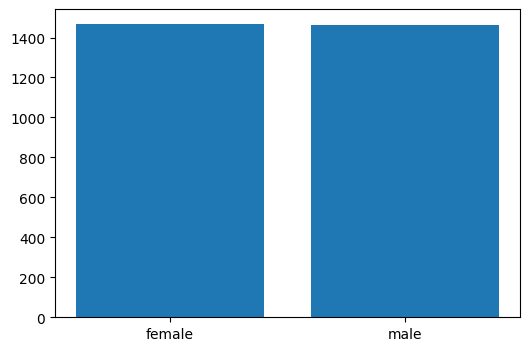

In [6]:
# data exploration
plt.figure(figsize=(6,4))
gender_counts = data['gender'].value_counts()
plt.bar(gender_counts.index, gender_counts.values)
plt.show()

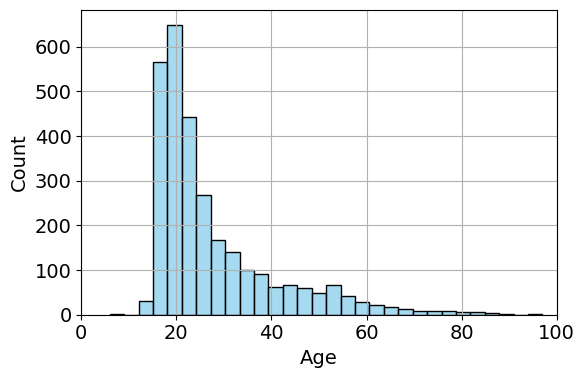

In [27]:
plt.rcParams["font.size"] = 14

# Plot the distribution of age
plt.figure(figsize=(6, 4))
sns.histplot(data=data, x='age', bins=30, color='skyblue')
#plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')


plt.tight_layout()
plt.xlim((0, 100))
plt.grid()
plt.savefig('age_distribution.pdf', bbox_inches="tight")
plt.show()

In [8]:
# Define the number of top categories to display
top_n = 10

# Get the counts of each ethnicity
ethnicity_counts = data['ethnicity'].value_counts()

# Select top N ethnicities
top_ethnicities = ethnicity_counts.head(top_n)

# Calculate the sum of the remaining categories
other_count = ethnicity_counts.iloc[top_n:].sum()

# Create a new column 'ethnicity_group' with top N ethnicities and 'Other'
data['ethnicity_group'] = data['ethnicity'].apply(lambda x: x if x in top_ethnicities.index else 'Other')

# Verify the new grouping
print(data['ethnicity_group'].value_counts())
data.drop(columns=['ethnicity_group'], inplace=True)

ethnicity_group
igbo          1081
Other          812
english        579
arabic         102
mandarin        65
french          63
korean          52
portuguese      48
russian         48
dutch           47
german          36
Name: count, dtype: int64


### Train the baseline model

In [9]:
# Random forest baseline
X_, y_, _, _ = trasform_data(data)
X_eval_, _, Ids_eval, _ = trasform_data(data_eval)
model = RandomForestRegressor()
RMSE = []
kf = KFold(5)
for train_indices, valid_indices in kf.split(X_):
        X_train = X_[train_indices]
        y_train = y_[train_indices]
        X_valid = X_[valid_indices]
        y_valid = y_[valid_indices]
        model.fit(X_train, y_train)

        y_pred = model.predict(X_valid)

        RMSE.append(np.sqrt(mean_squared_error(y_valid, y_pred)))
        print(RMSE[-1])
print(f"mean RMSE: {np.mean(RMSE):.3f}")

# model.fit(X_, y_)
# save_result(model, X_eval_, Ids_eval)

10.609280107705134
10.179998479247367
10.894599462489461
10.864044602710946
10.568122739583783
mean RMSE: 10.623


### Model Ensemble

In [10]:
svr_pipeline = make_pipeline(StandardScaler(), SVR(C = 50, epsilon =1.5, kernel = 'rbf'))
ridge_pipeline = make_pipeline(StandardScaler(), Ridge(alpha = 0.01, solver =  'lsqr'))

estimators = [
    ("SVR", svr_pipeline),
    ("Ridge", ridge_pipeline)
]

ensemble_regressor = StackingRegressor(estimators=estimators, final_estimator=Ridge(fit_intercept=False))

ensemble_regressor.fit(X, y)
y_pred = ensemble_regressor.predict(X)
save_result(ensemble_regressor, X_eval, Ids_eval)

print(f"final_estimator coefficients: SVR: {ensemble_regressor.final_estimator_.coef_[0]:.2f}, Ridge: {ensemble_regressor.final_estimator_.coef_[1]:.2f}")

ensemble_regressor

final_estimator coefficients: SVR: 0.75, Ridge: 0.28


StackingRegressor(estimators=[('SVR',
                               Pipeline(steps=[('standardscaler',
                                                StandardScaler()),
                                               ('svr',
                                                SVR(C=50, epsilon=1.5))])),
                              ('Ridge',
                               Pipeline(steps=[('standardscaler',
                                                StandardScaler()),
                                               ('ridge',
                                                Ridge(alpha=0.01,
                                                      solver='lsqr'))]))],
                  final_estimator=Ridge(fit_intercept=False))

In [11]:
param_grid = {
    'Ridge__ridge__alpha': [0.01, 0.05, 0.1],
    'SVR__svr__C': [30, 50, 80],
    'SVR__svr__epsilon': [0.5, 1, 1.5],
}

grid_search = GridSearchCV(estimator=ensemble_regressor, param_grid=param_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)

grid_search.fit(X, y)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print(f"Best parameters: {best_params}")

Best parameters: {'Ridge__ridge__alpha': 0.01, 'SVR__svr__C': 50, 'SVR__svr__epsilon': 1.5}


In [12]:
results = pd.DataFrame(grid_search.cv_results_)
results.sort_values(by="rank_test_score").head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_Ridge__ridge__alpha,param_SVR__svr__C,param_SVR__svr__epsilon,params,split0_test_score,split1_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
5,2.292725,0.070174,0.028158,0.000945,0.01,50,1.5,"{'Ridge__ridge__alpha': 0.01, 'SVR__svr__C': 5...",-84.309414,-93.516890,...,-75.906467,-100.551850,-99.259127,-93.764738,-126.481467,-97.778779,-92.141210,-96.708837,12.567872,1
14,2.286713,0.035508,0.029064,0.003078,0.05,50,1.5,"{'Ridge__ridge__alpha': 0.05, 'SVR__svr__C': 5...",-84.308542,-93.519842,...,-75.910253,-100.554923,-99.258881,-93.764612,-126.482404,-97.779946,-92.143288,-96.710037,12.567466,2
23,2.366149,0.111631,0.028139,0.001277,0.10,50,1.5,"{'Ridge__ridge__alpha': 0.1, 'SVR__svr__C': 50...",-84.307446,-93.523503,...,-75.914963,-100.558729,-99.258578,-93.764121,-126.483569,-97.781400,-92.145865,-96.711493,12.566969,3
4,2.505461,0.089490,0.030504,0.001757,0.01,50,1.0,"{'Ridge__ridge__alpha': 0.01, 'SVR__svr__C': 5...",-84.563523,-93.482122,...,-76.203108,-100.721600,-99.121622,-93.685183,-126.348213,-97.892986,-92.327564,-96.785234,12.468804,4
13,2.480632,0.066415,0.029891,0.000408,0.05,50,1.0,"{'Ridge__ridge__alpha': 0.05, 'SVR__svr__C': 5...",-84.562750,-93.485129,...,-76.206973,-100.724779,-99.121562,-93.685116,-126.349178,-97.894189,-92.329757,-96.786507,12.468382,5


In [13]:
# cross validation
model = ensemble_regressor
RMSE = []
kf = KFold(5)
for train_indices, valid_indices in kf.split(X):
        X_train = X[train_indices]
        y_train = y[train_indices]
        X_valid = X[valid_indices]
        y_valid = y[valid_indices]
        model.fit(X_train, y_train)

        y_pred_ = model.predict(X_valid)

        RMSE.append(np.sqrt(mean_squared_error(y_valid, y_pred_)))
        print(RMSE[-1])
print(f"mean RMSE: {np.mean(RMSE):.3f}")

9.584897108492719
9.688570600096932
10.030721455291783
10.525475884225946
9.739762839760925
mean RMSE: 9.914


In [14]:
#only SVR
svr_pipeline.fit(X, y)
# save_result(svr_pipeline, X_eval, Ids_eval)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svr', SVR(C=50, epsilon=1.5))])

In [15]:
#only Ridge
ridge_pipeline.fit(X, y)
# save_result(ridge_pipeline, X_eval, Ids_eval)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('ridge', Ridge(alpha=0.01, solver='lsqr'))])

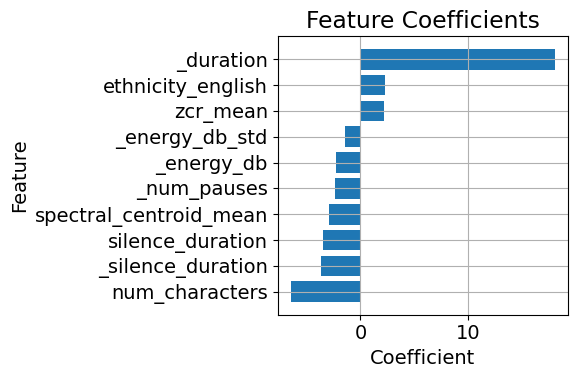

,Feature,Coefficient
9,_duration,18.081497
3,ethnicity_english,2.303487
1,zcr_mean,2.145949
0,_energy_db_std,-1.420929
2,_energy_db,-2.234557
4,_num_pauses,-2.330858
5,spectral_centroid_mean,-2.917364
6,silence_duration,-3.521201
7,_silence_duration,-3.682571
8,num_characters,-6.474693


In [16]:
coefficients = ensemble_regressor.estimators_[1][1].coef_

n = 10
sorted_indx = np.argsort(abs(coefficients))
top_n_indx = sorted_indx[-n:]

top_n_cols = [columns_name[i] for i in top_n_indx]

coefficients_df = pd.DataFrame({
    'Feature': top_n_cols,
    'Coefficient': coefficients[top_n_indx]
}).sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(6, 4))
plt.barh(coefficients_df['Feature'], coefficients_df['Coefficient'])
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.title('Feature Coefficients')
plt.gca().invert_yaxis()
plt.grid()
plt.tight_layout()
plt.show()

coefficients_df

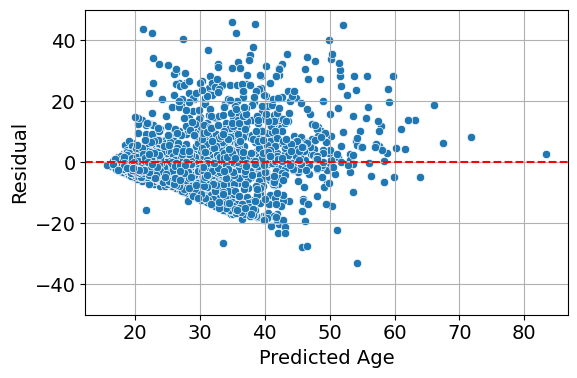

In [22]:
df = pd.DataFrame({'actual_age': y, 'predicted_age': y_pred})
df['residual'] = df['actual_age'] - df['predicted_age']

# Residual Plot
plt.figure(figsize=(6, 4))
sns.scatterplot(x='predicted_age', y='residual', data=df)
plt.axhline(0, color='red', linestyle='--')
#plt.title("Residuals vs Predicted Age")
plt.ylim((-50, 50))
plt.xlabel("Predicted Age")
plt.ylabel("Residual")
plt.tight_layout()
plt.grid()
plt.savefig('residual.pdf', bbox_inches="tight")
plt.show()

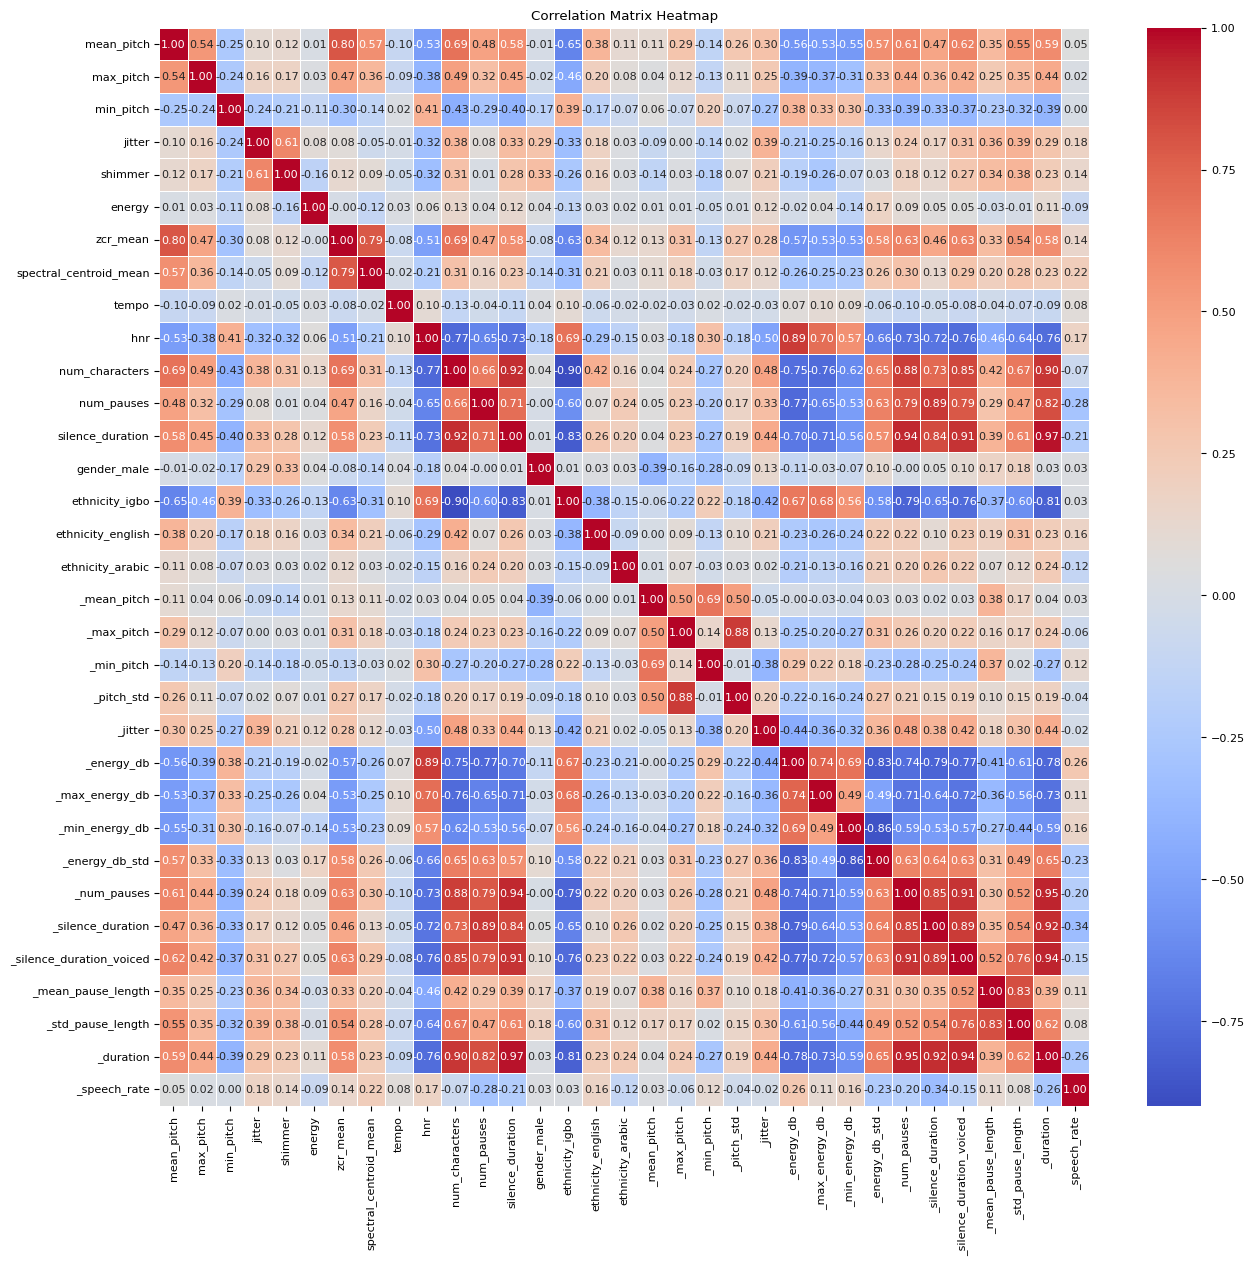

In [20]:
correlation_matrix = pd.DataFrame(X, columns=columns_name).corr()
plt.rcParams["font.size"] = 8
# Plot the heatmap
plt.figure(figsize=(15, 14))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()